In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import urllib.request
import pickle

import pandas as pd
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import numpy as np 
import matplotlib
import seaborn as sns
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

plt.style.use('ggplot')

import ipywidgets as widgets
from ipywidgets import interact, fixed

In [4]:
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-09-30")

In [5]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

def download_historical(url=DATA_URL, file=DATA_FILE):
    if not os.path.exists('data'):
        os.mkdir('data')
    urllib.request.urlretrieve(url, file)

def load_historical(file=DATA_FILE):
    # Load historical data from local file
    df = pd.read_csv(file,
        parse_dates=['Date'],
        encoding="ISO-8859-1",
        dtype={"RegionName": str,
               "RegionCode": str},
        error_bad_lines=False)
    return df

In [6]:
download_historical()
df = load_historical()

In [7]:
df.rename(columns=lambda x: x.replace(' ','_').replace('/','_'), inplace=True)

In [8]:
#Assignate the correct type
df.Date = pd.to_datetime(df['Date'], format='%Y%m%d')
df = df.astype({'C1_School_closing':'category', 'C2_Workplace_closing':'category', 
           'C3_Cancel_public_events':'category','C4_Restrictions_on_gatherings':'category',
           'C5_Close_public_transport':'category', 'C6_Stay_at_home_requirements':'category', 
           'C7_Restrictions_on_internal_movement':'category', 'C8_International_travel_controls':'category', 
           'E1_Income_support':'category', 'E2_Debt_contract_relief':'category', 
           'H1_Public_information_campaigns':'category', 'H2_Testing_policy':'category', 
           'H3_Contact_tracing':'category',  'CountryCode':'category',
           'H6_Facial_Coverings':'category', 'H7_Vaccination_policy':'category', 'M1_Wildcard':'category'})

In [9]:
#Jurisdiction, M1 and all the indexes can be dropped
df.drop(['Jurisdiction','M1_Wildcard', 'StringencyIndex', 'StringencyIndexForDisplay', 'StringencyLegacyIndex', 
        'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndex', 'GovernmentResponseIndexForDisplay',
        'ContainmentHealthIndex', 'ContainmentHealthIndexForDisplay', 'EconomicSupportIndex', 
        'EconomicSupportIndexForDisplay'], axis=1, inplace=True)

In [10]:
#Create feature for CountryName and Region
df['CountryRegion'] = df.RegionName
df.CountryRegion = df.CountryRegion.fillna(df.CountryName)

In [11]:
#Delete USA, UK only country data
indexes = list(df[((df.CountryRegion=='United States') | (df.CountryRegion=='United Kingdom'))].index)

#Delete Brazil and Canada regions
indexes.extend(df[((df.CountryName=='Brazil') & (df.RegionName.isna()==False))].index)
indexes.extend(df[((df.CountryName=='Canada') & (df.RegionName.isna()==False))].index)

#Delete Turkmenistan, Tonga and Malta
indexes.extend(df[((df.CountryName=='Tonga') | (df.CountryName=='Turkmenistan')) | (df.CountryName=='Malta')].index)

df.drop(labels = indexes, axis=0, inplace=True)

In [12]:
#Create new variables for day, month and year
df['Month'] = df.Date.apply(lambda x: x.month)
df['Year'] = df.Date.apply(lambda x: x.year)
df['Day'] = df.Date.apply(lambda x: x.day)

In [13]:
#Initialized values to 0 in categorical variables to then fill na with the previous value
df.loc[(df['Date']=='2020-01-01'), 'C1_School_closing'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C2_Workplace_closing'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C3_Cancel_public_events'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C4_Restrictions_on_gatherings'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C5_Close_public_transport'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C6_Stay_at_home_requirements'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C7_Restrictions_on_internal_movement'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C8_International_travel_controls'] = 0
df.loc[(df['Date']=='2020-01-01'), 'E1_Income_support'] = 0
df.loc[(df['Date']=='2020-01-01'), 'E2_Debt_contract_relief'] = 0
df.loc[(df['Date']=='2020-01-01'), 'H1_Public_information_campaigns'] = 0
df.loc[(df['Date']=='2020-01-01'), 'H2_Testing_policy'] = 0
df.loc[(df['Date']=='2020-01-01'), 'H3_Contact_tracing'] = 0
df.loc[(df['Date']=='2020-01-01'), 'H6_Facial_Coverings'] = 0
df.loc[(df['Date']=='2020-01-01'), 'H7_Vaccination_policy'] = 0

In [14]:
#Fill NaN values by 0
df.C1_School_closing.fillna(method='ffill', inplace=True)
df.C2_Workplace_closing.fillna(method='ffill', inplace=True)
df.C3_Cancel_public_events.fillna(method='ffill', inplace=True)
df.C4_Restrictions_on_gatherings.fillna(method='ffill', inplace=True)
df.C5_Close_public_transport.fillna(method='ffill', inplace=True)
df.C6_Stay_at_home_requirements.fillna(method='ffill', inplace=True)
df.C7_Restrictions_on_internal_movement.fillna(method='ffill', inplace=True)
df.C8_International_travel_controls.fillna(method='ffill', inplace=True)
df.E1_Income_support.fillna(method='ffill', inplace=True)
df.E2_Debt_contract_relief.fillna(method='ffill', inplace=True)
df.E3_Fiscal_measures.fillna(0, inplace=True)
df.E4_International_support.fillna(0, inplace=True)
df.H1_Public_information_campaigns.fillna(method='ffill', inplace=True)
df.H2_Testing_policy.fillna(method='ffill', inplace=True)
df.H3_Contact_tracing.fillna(method='ffill', inplace=True)
df.H4_Emergency_investment_in_healthcare.fillna(0, inplace=True)
df.H5_Investment_in_vaccines.fillna(0, inplace=True)
df.H6_Facial_Coverings.fillna(method='ffill', inplace=True)
df.H7_Vaccination_policy.fillna(method='ffill', inplace=True)

In [15]:
flags = ['C1_Flag', 'C2_Flag', 'C3_Flag', 'C4_Flag', 'C5_Flag', 'C6_Flag', 'C7_Flag', 'E1_Flag', 'H1_Flag', 'H6_Flag', 'H7_Flag']
for col in flags:
    df[col].fillna(2, inplace=True)
    df[col] = df[col].apply(lambda x : 1 if x==1 else (0.5 if x==0 else 0))

In [16]:
#Confirmed cases fill na with previous values
df.loc[(df['Date']=='2020-01-01'), 'ConfirmedCases'] = 0
df.ConfirmedCases.fillna(method='ffill', inplace=True)

In [17]:
#Confirmed deaths fill na with previous values
df.loc[(df['Date']=='2020-01-01'), 'ConfirmedDeaths'] = 0
df.ConfirmedDeaths.fillna(method='ffill', inplace=True)

In [18]:
NPI_COLUMNS = ['C1_School_closing',
               'C2_Workplace_closing',
               'C3_Cancel_public_events',
               'C4_Restrictions_on_gatherings',
               'C5_Close_public_transport',
               'C6_Stay_at_home_requirements',
               'C7_Restrictions_on_internal_movement',
               'C8_International_travel_controls',
               'H1_Public_information_campaigns',
               'H2_Testing_policy',
               'H3_Contact_tracing',
               'H6_Facial_Coverings']

In [29]:
spdf = pd.DataFrame(df[df.CountryName=='Spain'])

spdf['NewCases'] = spdf.sort_values('Date').ConfirmedCases.diff()
spdf.NewCases = spdf.NewCases.apply(lambda x: 0 if x<0 else x)

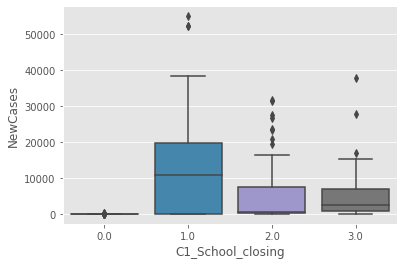

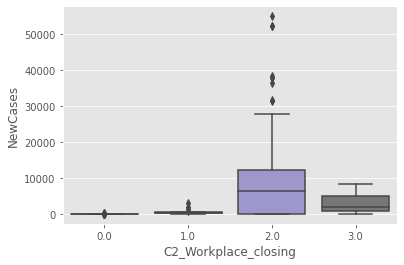

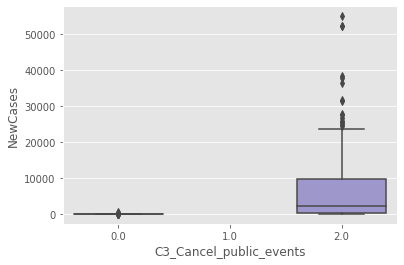

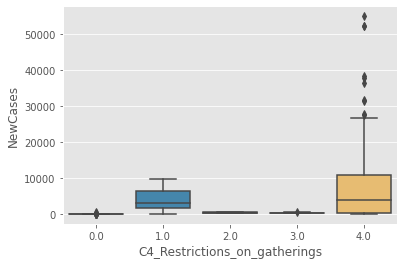

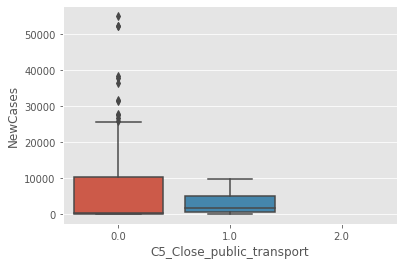

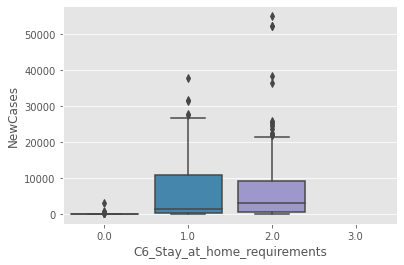

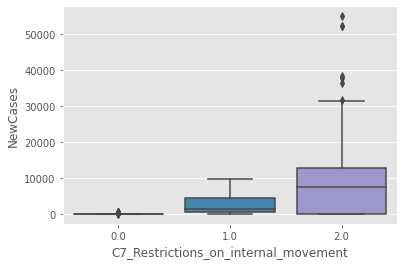

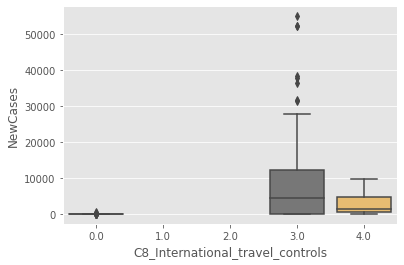

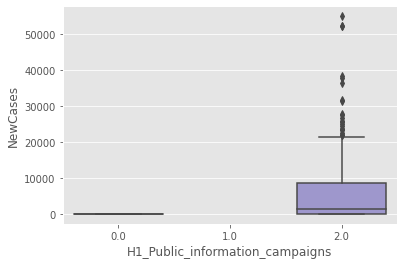

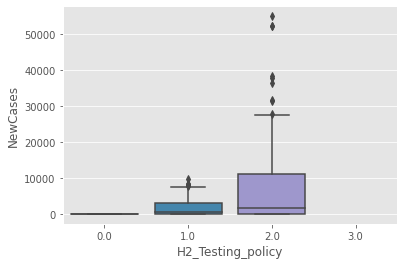

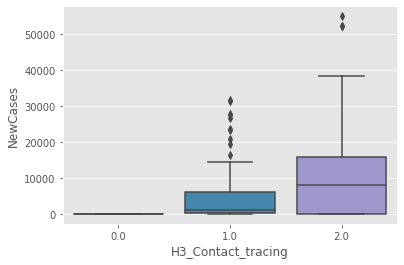

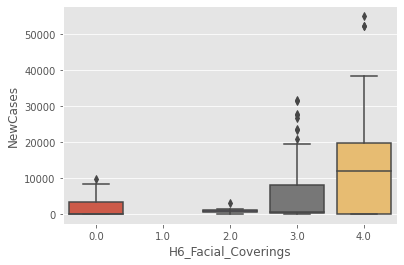

In [40]:
for col in NPI_COLUMNS:
    sns.boxplot(x=str(col), y="NewCases", data=spdf)
    plt.show()

# Model

In [20]:
def split_historical(df, split_date):
    df_train = df[df.Date <= split_date]
    df_test = df[df.Date > split_date]
    return df_train, df_test

In [21]:
print("Spliting at : ", HYPOTHETICAL_SUBMISSION_DATE)
df_train, df_test = split_historical(df, HYPOTHETICAL_SUBMISSION_DATE)

Spliting at :  2020-09-30


In [22]:
X_train = df_train.drop(['ConfirmedCases', 'Date', 'CountryName', 'CountryCode', 'RegionName', 'RegionCode',
                         'CountryRegion', 'ConfirmedDeaths'], axis=1)
y_train = df_train.ConfirmedCases 
X_test = df_test.drop(['ConfirmedCases', 'Date', 'CountryName', 'CountryCode', 'RegionName', 'RegionCode',
                         'CountryRegion', 'ConfirmedDeaths'], axis=1)
y_test = df_test.ConfirmedCases 

ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=6), n_estimators=400)
ada.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6),
                  n_estimators=400)

In [23]:
# Predict
y_ada = ada.predict(X_test)

In [24]:
def mae(pred, true):
    return np.mean(np.abs(pred - true))

In [25]:
mae(y_ada, y_test)

198205.58039685574

In [26]:
df_predicted = pd.DataFrame(df_test[['CountryName', 'RegionName', 'Date']])
df_predicted['PredictedDailyNewCases'] = y_ada

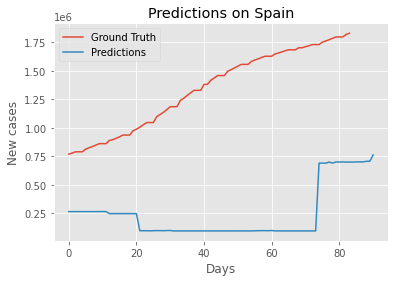

In [27]:
start_date = '2020-09-30'
end_date = '2020-12-22'
plt.figure()
country_name = "Spain"

plt.title('Predictions on Spain')

start_date_dt = pd.to_datetime(start_date, format='%Y-%m-%d')
end_date_dt = pd.to_datetime(end_date, format='%Y-%m-%d')

y1 = df[(df.CountryName == country_name) & (df.Date>=start_date_dt) & (df.Date<=end_date_dt)].ConfirmedCases.to_list()
y2 = df_predicted[df_predicted.CountryName == country_name].PredictedDailyNewCases.to_list()

plt.xlabel('Days')
plt.ylabel('New cases')

plt.plot(y1, label="Ground Truth")
plt.plot(y2, label="Predictions")


plt.legend()
plt.show()